# Solving Sudokus with a Genetic Algorithm


## Introduction
Sudoku is a very popular japanese game invented in the 70s. The objective is to fill in a grid of 9x9 cells
with digits, so that in each column, in each row and in each 3x3 grid there is exactly one digit from 1-9. The following
image shows an example of a Sudoku puzzle.

<p><a href="https://commons.wikimedia.org/wiki/File:Sudoku-by-L2G-20050714.svg#/media/Archivo:Sudoku-by-L2G-20050714.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Sudoku-by-L2G-20050714.svg/1200px-Sudoku-by-L2G-20050714.svg.png" alt="Sudoku-by-L2G-20050714.svg" style="width: 300px;"></a><br> <a href="https://commons.wikimedia.org/w/index.php?curid=1167411">wikipedia</a></p>

We can model this problem as a combinatorial optimization problem and apply different combinatorial algorithms and heuris-
tics to solve it. Although it clearly might not be the best alternative, we are going to use genetic algorithm to solve Sudoku.



##Requirements

In [ ]:
!pip install numpy

## Approach 1: Naive approach
One of the main advantages of genetic algorithms is that we do not need to have a priori an in-depth knowledge of the
problem, we can use simple rules or heuristics to generate the genome of each iteration, and let the fitness function
select the fittest alternative.
The simplest way to model the Sudoku as a combinatorial optimization problem would be to regard the solution as a
permutation of the missing digits. For instance, if we look at the solution of the example above:

<p><a href="https://commons.wikimedia.org/wiki/File:Sudoku-by-L2G-20050714.svg#/media/Archivo:Sudoku-by-L2G-20050714.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Sudoku_Puzzle_by_L2G-20050714_solution_standardized_layout.svg/1200px-Sudoku_Puzzle_by_L2G-20050714_solution_standardized_layout.svg.png" alt="Sudoku-by-L2G-20050714.svg" style="width: 300px;"></a><br>Tim Stellmach - public domain, <a href="https://commons.wikimedia.org/w/index.php?curid=1167411">wikipedia</a></p>

We can actually assign to every unknown cell an index from 1 to the number of unknowns, from left to right and top to bottom, such that the solution is the ordered set:

$s = (s_1, s_2, ..., s_N) = (4, 6, 8, 9, 1, 2, 7, 2, 3, 4, 8, 1, 3, 4, 2, 4, 7, 5, 9, 7, 1, 4, 2, 2, 6, 5, 7, 9, 1, 3, 9, 4, 8, 5, 9, 1, 5, 3, 7, 4, 2, 8, 7, 6, 3, 3, 4, 5, 2, 6, 1)$

At the beginning of the problem, we do not know the exact value that we need to assign to each cell, that is, we do not know that $s_1 = 4$ or that $s_5 = 5$, but we know that it will be a value that is missing, and
it is very easy to calculate the values that are missing, just by counting the digits that are present, because we know that each digit appears nine time in the solution. So, with this simple procedure, we can determine at the beginning of the problem which are the digits that are missing:

$$c = \{1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 9, 9, 9, 9, 9\}$$

And we know that the solution $s$ is going to be a [permutation](https://en.wikipedia.org/wiki/Permutation) of these elements!

We need to find the right permutation though, and there are $N!$ number of permutations, where $N$ is as noted above the
total number of missing digits in our problem. In this case $N=51$ so there are:

$$N! = 51! = 1551118753287382280224243016469303211063259720016986112000000000000$$

possible combinations, which are many! Luckily for us, there are [repetitions](https://en.wikipedia.org/wiki/Permutation#Permutations_with_repetition), since some digits
are repeated. This yields the following number of permutations:

$$\frac{51!}{6!·7!·6!·8!·5!·4!·6!·4!·5!}=2465536997482928914408092530982635167547392$$

Which is still a really large number of possible combinations! The question is, are they too many for a genetic algorithm
to find a solution?
We will find out soon enough, but first, let's discuss how our genetic algorithm is going to work. Step by step:

### Initialisation
The first step is to generate an initial **genome** (all genes of a set of possible solutions). A gene is going to
represent the value of a digit in a position of the Sudoku, and all the genes or chromosome of a solution, all the values
of all digits missing in the problem.
Basically, to generate the genome of the first population, we can generate just as many different permutations of c as
the size of the initial population. Say the initial population size is $P$, so initialising the genome is basically to
obtain $P$ permutations of $c$. Let us define a function $\tau(c)$ that randomly re-arranges the items of an array $c$
and therefore returns a random permutation out of all possible permutations. so, our initial genome $G_0$ is going to
be just a set of permutations of c:

$$G_0 = [g_{01}, g_{02}, ...g_{0P}]$$

$$g_{0k} = \tau(c) \quad \forall k \in [1, P]$$

As a reference, the numpy function [shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) provides such a re-arrangement.


###  Fitness function
Now, the second step is to evaluate the fitness function. We can define a fitness function that counts the number of
duplicated digits in every row, in every column, and in every 3x3 block. That is, if a digit appears two times in a row,
the fitness function will add 1, and if a digit appears twice in a column, it will add 1, same if it appears twice in a
block. So let us define this fitness function as $f(g_{ik})$ and obviously the result is going to be an integer number.
Furthermore, the $fitness array$:

$$f_0 = [f(g_{01}), f(g_{02}), ..., f(g_{0P})]$$

will contain the fitness of the different candidate solutions in the initial population, and by extension:

$$f_i = [f(g_{i1}), f(g_{i2}), ..., f(g_{iP})]$$

will contain the fitness of the different candidate solutions in the population at generation $i$.

### Selection function
To select the fittest, we just need to select the candidates that contain less mistakes, those where the fitness solution
is lower. We just need to sort the elements of the fitness array in ascending order and select some of them for the next
generation. Let us note the selection function as $\sigma(f_i)$ and as $S$ the number of individuals
that will produce offspring in the next generation. The set of survivals in a generation $i$ is:

$$s_i = \sigma(f_i) = [s_{i1}, s_{i2}, ..., s_{iS}]$$

where as described, the elements of s will be the $S$ elements of $G_i$ with the lowest fitness function value.

### Crossover and mutation
We could randomly select two parents from the survivals and combine values in the solution, but we need to ensure that
the result is still a permutation of $c$, so for the sake of simplicity, let us not implement any crossover function and
focus on the generation of mutations of surviving individuals. To generate a mutation, what we can do is copy some of
values randomly from the parent in the exact same position as they are in the parent, and shuffle the remaining values.
For instance, imagine that our problem was very easy and only missing 3 values. We could select randomly 1 out of the 3
values and copy it in the exact same location and generate a permutation of the other two elements. If the parent had
all the digits of a valid solution, so will the children, and if we are lucky, the permutation will yield a valid
solution.
Let us note as $R$ the number of digits (or genes) of the parent that we copy, and $N-R$ the number of genes that mutate.
Note that, if we select randomly the $(R)$ genes out of the $N$ genes, this is a combination, and therefore, the number
of possible combinations of $R$ genes out of the parent is:

$$C^N_R = \frac{N!}{R!(N-R)!}$$

And now, we are going to shuffle the $(N-R)$ remaining genes, so there are  $(N-R)$ different permutations of these
genes, that combined with the previous result, yield the following total possible different offspring from a single
parent:

$$\frac{N!}{R!}$$


For instance, the example above, with $N=51$ gaps or blank positions, if we set $R=49$, there are:

$$C^{51}_{49} = \frac{N!}{R!(N-R)!} = \frac{51!}{49!(51-49)!} = \frac{51*50*49!}{49!*2!} = \frac{51*50}{2!} = 1275$$

possible ways to combine the genes, and if we multiply by $2!$, we get 2500 different combinations of a parent.
Now, this is only for 1 parent, if the selection function lets $S$ survivals, we need to multiply by this factor as well
to get the total size of the possible offspring, so for instance, if we set it to 10, the possible different members
in a generation is 25000.

We really need to fine tune these parameters to make sure that the algorithm is fast, because we need to make sure that
we explore a sufficient proportion of all the possible offspring in the iterations. For instance if $R$ is too small,
the number of possible children will be too large compared to the population size, and it will be very difficult for the
algorithm to find the right solution. Additionally, $(N-R)$ must be at least 2, so that we can at least switch two digits
to generate another solution. On the other hand, if the population size is too large compared to the possible offspring
our algorithm is inefficient because the population size is too large compared to the possible different offspring, and
we will be evaluating several times the same combination of genes in every generation. As a rule of thumb, You need to
make sure that the total number of different offspring in a generation is larger than the population size but in the
same order of magnitude.

### Termination
Finally, we will terminate when we reach a maximum number of iterations, or when we have found the optimal solution.
We also need to ensure that we can get rid of *bad batches*, meaning that something can go wrong in the mutations and
our algorithm can converge to a solution that can not be fixed with a permutation of N-R numbers of all candidate
solution, that is the fitness function can have *local minimum* and our solution can converge to a local minimum, which
is not optimal, so if we detect for instance that the fitness function does not change in a number of iterations,
we just go back to step 1 and initialise the entire population again. We also need to set another parameter to control
the reset, which will represent the maximum number of iterations without improvement in the fitness function.


### Implementation
Ok, the following Python script implements this approach. To try it, you just need to provide the values of your Sudoku
as a Python Array where the digits in [1-9] define the clues or filled digits in your Sudoku, and the 0s represent the
gaps.

#### Hyper-parameters
The parameters that control the behaviour of the algorithm, or hyper-parameters are as described above:
- Number of genes that are passed to children in each generation (R). Default: N-R = 2
- Population size, the population size of each generation (P), default: 500
- Number of iterations, default: 1000:
- Number of survivals in each generation, default 10
- Number of iterations without improvement, default 10


all righty, i finished the Sudoku in 243.800067 seconds and 1000 iterations: 
Best solution is:
[[8. 7. 6. 2. 2. 9. 6. 1. 5.]
 [9. 5. 2. 3. 4. 8. 7. 9. 2.]
 [4. 3. 9. 1. 5. 7. 3. 4. 9.]
 [7. 9. 3. 4. 8. 5. 8. 1. 6.]
 [6. 3. 5. 7. 1. 4. 2. 8. 4.]
 [1. 8. 4. 6. 2. 3. 9. 5. 7.]
 [5. 6. 8. 9. 3. 4. 2. 7. 1.]
 [3. 2. 9. 1. 5. 8. 1. 7. 8.]
 [6. 4. 7. 1. 2. 6. 5. 6. 3.]]


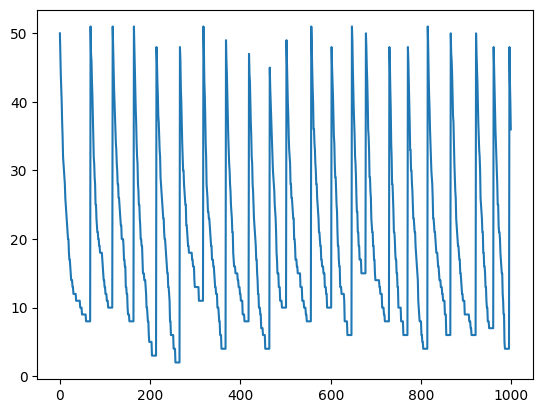

In [ ]:
from random import sample
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

# digits from 1 to 9
digits = np.arange(1,10)

problem = np.array([[8, 0, 6, 2, 0, 9, 0, 1, 5],
                    [9, 5, 0, 3, 0, 8, 7, 0, 0],
                    [4, 0, 0, 1, 0, 0, 3, 0, 9],
                    [7, 9, 3, 4, 8, 5, 0, 0, 0],
                    [0, 0, 0, 7, 0, 0, 0, 0, 4],
                    [0, 8, 4, 6, 0, 3, 9, 5, 7],
                    [0, 0, 0, 0, 3, 4, 2, 0, 0],
                    [3, 0, 9, 0, 0, 0, 1, 0, 8],
                    [6, 0, 7, 0, 2, 0, 0, 0, 3]])

# clues idx is a tuple that contains the coordinates of the clues.
# It can be used for indexing non zero values in the problem
clues_idx = np.nonzero(problem)

# Conversely, gaps_idx is a tuple that contains the coordinates of the zeros.
# It is used for indexing the values we need to fill in.

gaps_idx = np.nonzero(problem == 0)

# We know that a valid solution is a permutation of the digits from 1 to 9 repeated 9 times. Let us find the digits that
# are missing. digit_count counts, starting with zero the number of digits present in the problem:
digit_count = np.bincount(problem.flatten())

# the size of the problem (N):
problem_size = digit_count[0]

# HYPER-PARAMETERS
# Hyper-parameter R, default: N-R = 2
in_chromosome_size = problem_size -2

# Hyper-parameter 2, population size, default: 500
population_size = 500

# Hyper parameter 3, number of iterations, default: 1000:
num_iter = 1000

# Hyper parameter 4, number of survivals in each generation: default 10
num_survivals = 10
# Hyper parameter 5, Number of iterations without improvement: default: 10
reset_it = 10

# The missing values are going to be 9 - the count of digits, the zeros can be ignored:
missing_count = 9 - digit_count

# OK, let´s start
init_time = datetime.now()

# Let´s create a numpy array with the digits that we need to fill in:
candidate_digits = np.array([], dtype='int32')


for digit in digits:
    candidate_digits = np.append(candidate_digits, np.repeat(digit, missing_count[digit]))


def is_permutation(elements):
  # returns 0 if row is a permutation of digits from 1 to 9
  return 9 - len(np.unique(elements))

def fitness(solution):
  res = 0
  # check that rows are consistent
  for i in range(9):
    res += is_permutation(solution[i])

  # check that columns are consistent
  for j in range(9):
    res += is_permutation(solution[:,j])

  # check that blocks are consistent
  for k in range(9):   #      0, 1, 2, 3, 4, 5, 6, 7, 8
    row_index = 3*(k//3)   # 3 * (0, 0, 0, 1, 1, 1, 2, 2, 2)
    col_index = 3*(k%3)    # 3 * (0, 1, 2, 0, 1, 2, 0, 1, 2)
    res += is_permutation(solution[row_index:row_index + 3, col_index:col_index+3])

  # check consistency with problem definition
  # indices of clues
  res += sum(abs(problem[clues_idx]-solution[clues_idx]))

  # check if solution is complete
  res += np.sum(solution == 0)
  return res



# our genome consists of shuffling the candidate digits and placing the digits in the
# gaps

genome = np.zeros((population_size, 9, 9))

for k in range(population_size):
    # suffle the candidates
    np.random.shuffle(candidate_digits)

    #init candidate as problem
    genome[k, :, :] = np.copy(problem)
    #fill in sudoku, by placing the digits where the problem is zero
    np.place(genome[k, :, :], genome[k, :, :] == 0, candidate_digits)

# The simplest genome generation strategy is however to just fill the zeros with digits
# np.place(genome, genome==0, [1, 2, 3, 4, 5, 6, 7, 8, 9])

it = 0
iteration_error = np.zeros(num_iter)
while it < num_iter:
    # reset the fitness function
    fitness_array = np.zeros(population_size)

    for k in range(population_size):
        # calculate fitness function of candidate k
        fitness_array[k] = fitness(genome[k,:,:])


    # Find the fittest!
    fitness_array_sorted_idx = np.argsort(fitness_array)
    fittest = fitness_array_sorted_idx[0:num_survivals]

    iteration_error[it] = fitness_array[fittest[0]]
    reset = (it >= reset_it) and (sum(abs(iteration_error[it-reset_it:it] - iteration_error[it])) == 0)
    if reset:

        digit_count = np.bincount(problem.flatten())

        # The missing values are going to be 9 - the count of digits, the zeros can be ignored:
        missing_count = 9 - digit_count

        # Let´s create a numpy array with the digits that we need to fill in:
        candidate_digits = np.array([], dtype='int32')


        for digit in digits:
            candidate_digits = np.append(candidate_digits, np.repeat(digit, missing_count[digit]))

        genome = np.zeros((population_size, 9, 9))

        for k in range(population_size):
            # suffle the candidates
            np.random.shuffle(candidate_digits)

            #init candidate as problem
            genome[k, :, :] = np.copy(problem)
            #fill in sudoku, by placing the digits where the problem is zero
            np.place(genome[k, :, :], genome[k, :, :] == 0, candidate_digits)

        continue

    sol = genome[fittest[0],:,:]
    # print('Iteration: ' + str(it))
    # print(iteration_error[it])
    # print(sol)    # We might have found already a solution

    if fitness_array[fittest[0]] == 0:
        break
    else:
        # Let us create the next generation
        # take ten survivals
        mutations = np.zeros((population_size,9,9))
        # randomly combine rows of the best solutions
        for k in range(population_size):
            # Init mutation_k as problem
            mutation_k = np.copy(problem)


            # we select the parent randomly from the survivals
            np.random.shuffle(fittest)
            parent_a = genome[fittest[0],:,:]


            # we first select some of the values to fill in randomly
            pos_to_fill_in_a = np.random.choice(np.arange(problem_size), 95*problem_size//100, replace=False)

            mutation_idx_a = (gaps_idx[0][pos_to_fill_in_a], gaps_idx[1][pos_to_fill_in_a])

            # we fill in the values selecting them from the parent
            mutation_k[mutation_idx_a] = parent_a[mutation_idx_a]

            # Now we fill in the rest of the values randomly
            digit_count = np.bincount(mutation_k.flatten())

            missing_count = 9 - digit_count
            candidate_digits = np.array([], dtype='int32')
            for digit in digits:
                candidate_digits = np.append(candidate_digits, np.repeat(digit, missing_count[digit]))

            np.random.shuffle(candidate_digits)
            np.place(mutation_k, mutation_k == 0, candidate_digits)


            mutations[k,:,:] = np.copy(mutation_k)

        # copy mutation to genome
        genome = np.copy(mutations)

        # We increase the number of iterations
        it+=1

end_time = datetime.now()
duration = end_time - init_time
print("all righty, i finished the Sudoku in {0} seconds and {1} iterations: ".format(duration.total_seconds(), it))
print("Best solution is:")
print(sol)
plt.plot(iteration_error)


### Questions
1. Run the algorithm above and write down the number of iterations and the execution time. Did the algorithm find an
optimal solution? Do you think the algorithm is faster than a human?

2. As described above, the algorithm may converge to a *local minimum*, a solution with a low number of errors, but that
cannot be fixed with a permutation of digits. If the algorithm detects that there is no improvement, it will reset the
entire population and start again. Looking at the graph that shows the error against the iterations, do you
think the algorithm reset the entire population at any time? How many times do you think the solution was reset?

3. Look at the description of the strategy taken, what changes in the hyper-parameters of the algorithm would you do to
speed up the execution? Try changing the parameters according to your theory and check if you are able to improve the
execution time?

4. How stable is the algorithm? Can you comment on the sensibility of the algorithm? Do you think it can solve any Sudoku?

## Approach 2: Columns approach
Approach 1 is naive in the sense that it does not require an in-depth knowledge of Sudoku to program the algorithm, but
obviously, if we have some knowledge of the problem at hand, we can deliver more efficient solutions, but they might come
at the expense of complexity, and therefore costs, development costs and/or computational costs.

Let us again look at the solution of the problem above:
<p><a href="https://commons.wikimedia.org/wiki/File:Sudoku-by-L2G-20050714.svg#/media/Archivo:Sudoku-by-L2G-20050714.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Sudoku_Puzzle_by_L2G-20050714_solution_standardized_layout.svg/1200px-Sudoku_Puzzle_by_L2G-20050714_solution_standardized_layout.svg.png" alt="Sudoku-by-L2G-20050714.svg"></a><br>Tim Stellmach - public domain, <a href="https://commons.wikimedia.org/w/index.php?curid=1167411">wikipedia</a></p>

We know that each column is a permutation of the digits in [1-9], so, what if instead of assigning to every unknown cell
an index, we use two indices, one for the columns, and another one for the rows. for instance, now our solution will be

- Column 1: $[s_{31}, s_{71}, s_{71}, s_{71}] = [1, 9, 2, 3]$
- Column 2: $[s_{22}, s_{42}, s_{52}, s_{62}, s_{82}, s_{92}] = [7, 5, 2, 1, 8, 4]$
- Column 3: $[s_{13}, s_{23}, s_{43}, s_{53}, s_{63}, s_{73}, s_{83}, s_{93}] = [4, 2, 9, 6, 3, 1, 7, 5]$
- Column 4: $[s_{14}, s_{34}, s_{44}, s_{64}, s_{74}, s_{94}] = [6, 3, 7, 9, 5, 2]$
- Column 5: $[s_{35}, s_{55}, s_{75}] = [4, 5, 3]$
- Column 6: $[s_{16}, s_{36}, s_{46}, s_{56}, s_{96}] = [8, 2, 1, 4, 7, 6]$
- Column 7: $[s_{17}, s_{27}, s_{37}, s_{47}, s_{57}, s_{67}, s_{87}, s_{97}] = [9, 3, 5, 4, 7, 8, 6, 1]$
- Column 8: $[s_{18}, s_{28}, s_{48}, s_{58}, s_{68}, s_{88}] = [1, 4, 2, 9, 5, 3]$
- Column 9: $[s_{19}, s_{29}, s_{39}, s_{79}] = [2, 8, 7, 4]$


Again, even if at the beginning of the problem we do not know the exact value that we need to assign to each cell,
it is very easy to know which values are going to be missing in each column, and we know that in the solution, the values
in each column is going to be a permutation of the missing values. So, now, our problem consists of finding 9
permutations of different sizes! what is now the number of potential solutions, the search space? well, it depends on
the problem, but in this specific case, we need to multiply the number of possible combinations in each row, therefore
the number of candidate solution in this case is:

$$N_1!*N_2!*N_3!*N_4!*N_5!*N_6!*N_7!*N_8!*N_9! = 4!*6!*8!*6!*3!*6!*8!*3!*4! = 12582400952578867200000$$

Compared to alternative 1:

$$\frac{51!}{6!·7!·6!·8!·5!·4!·6!·4!·5!}=2465536997482928914408092530982635167547392$$

The search space is now tiny!

### Initialisation
Again, the first step is to generate an initial **genome** (all genes of a set of possible solutions). A gene is going to
represent the value of a digit in a position of the Sudoku, and all the genes or chromosome of a solution, all the values
of all digits missing in the problem.
Basically, to generate the genome of the first population, we can generate just as many permutations of the
values missing in each column as the size of the initial population. Let us note as $c_j \quad j \in [1-9]$ the set of
missing values in column $j$. Basically, we need to obtain $P$ permutations of every $c_j$.  
We can use the same function $\tau(c_j)$ to re-arranges the items of an array $c$ and returns a random permutation out
of the $N_j!$ possible permutations. so, our initial genome $G_0$ is going to be P different sets of permutations of the 9 columns:

$G_0 = [g_{01}, g_{02}, ...g_{0P}]$

$g_{0k} = [\tau(c_j) \quad \forall k \in [1, P] \forall j \in [1-9]$

Again, the numpy function [shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) provides such a re-arrangement.


###  Fitness function
We can use the same fitness function as in the previous approach.

### Selection function
We can apply the same selection function as in the previous approach.

### Crossover and mutation
Now, let us take a different approach for the cross-over, what we are going to do is to take a number of columns from the
parent, and copy them, and then create a mutation by shuffling some of the values of the remaining columns.

Let us note as $R_c$ the number of columns that are passed to the children without mutations. Again, this is a combination
of the 9 columns, and the number of possible combinations is:

$C^9_{R_c} =  \frac{9!}{R_c!(9-R_c)!}$

For instance, if we set this parameter to 8, there are 9 possible combinations.

Now, we are going to mutate the remaining columns. Let us refer to column j to one of the columns that will mutate.
In this case, Let us note as $N_j$ the unknown digits in column j, $R_j$ the number of digits (or genes) of the
parent that we copy to column j, and $N_j-R_j$ the number of genes that mutate in that column. There are:

$C^{N_j}_{R_j} = \frac{N_j!}{R_j!(N_j-R_j)!}$

Possible combinations of genes and $(N_j-R_j)!$ permutations of the genes that mutate. So, again, there are:

$C^{N_j}_{R_j}*(N_j-R_j)! = \frac{N_j!}{R_j!}$

Again, this is a combination, but note that, now, the index of the column j is random (we did a random selection of
columns), so the maximum number of digits missing are found in columns 3 and 7 that are both missing 8 numbers.
So, for instance, if we set $R_c$ to 8, so that we copy 8 columns from the parent, there will be 9 combinations of columns
to pass as-is to the next generation.
Now, say we fix $(N_j - R_j) to 2, so that we shuffle at most 2 values. We will have, at most:

$9*\frac{8!}{6!} = 9*8*7 = 504$

Possible ways to mutate a parent if the algorithm selects to mutate column 3 or column 7. And if we select 10 survivals,
we may get an estimation of the total number of offspring as 5040.

There are two things that we need to observe here. First is that the number of combinations is significantly smaller,
just as the search space, so we can deal with smaller populations in every generation, which will make each iteration
faster, or take another strategies, like increasing the number of survivals in each generation, or the number of
 columns that we shuffle, to explore the search space faster.

The other important thing is that there is uncertainty in the total number of possible offspring, because not
all the columns are missing the same number of values and, since the parameters of the algorithm are fixed, the algorithm
is not going to be as stable as in the first approach.

### Termination
We will terminate using the same approach as before.


### Implementation
Ok, the following Python script implements this approach. To try it, you just need to provide the values of your Sudoku
as a Python Array where the digits in [1-9] define the clues or filled digits in your Sudoku, and the 0s represent the
gaps.

#### Hyper-parameters
The parameters that control the behaviour of the algorithm, or hyper-parameters:
- Number of columns that are passed to the next generation ($R_c$). Default: 8
- Number of genes that are passed to children in each generation (R). Default: 2
- Population size, the population size of each generation (P), default: 50
- Number of iterations, default: 1000:
- Number of survivals in each generation, default 10
- Number of iterations without improvement, default 100



all righty, i finished the Sudoku in 3.3565 seconds and 113 iterations: 
Best solution is:
[[8. 3. 6. 2. 7. 9. 4. 1. 5.]
 [9. 5. 1. 3. 4. 8. 7. 6. 2.]
 [4. 7. 2. 1. 5. 6. 3. 8. 9.]
 [7. 9. 3. 4. 8. 5. 6. 2. 1.]
 [1. 6. 5. 7. 9. 2. 8. 3. 4.]
 [2. 8. 4. 6. 1. 3. 9. 5. 7.]
 [5. 1. 8. 9. 3. 4. 2. 7. 6.]
 [3. 2. 9. 5. 6. 7. 1. 4. 8.]
 [6. 4. 7. 8. 2. 1. 5. 9. 3.]]


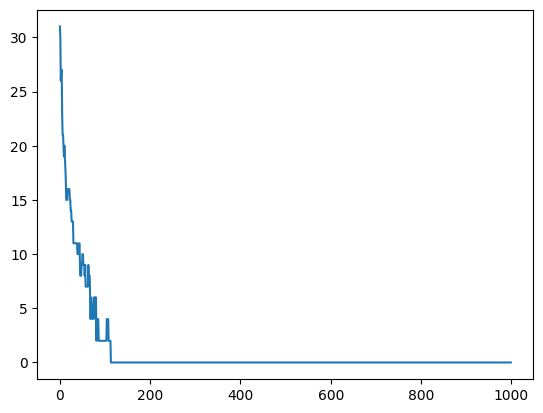

In [ ]:
from random import sample
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

# digits from 1 to 9
digits = np.arange(1,10)

problem = np.array([[8, 0, 6, 2, 0, 9, 0, 1, 5],
                    [9, 5, 0, 3, 0, 8, 7, 0, 0],
                    [4, 0, 0, 1, 0, 0, 3, 0, 9],
                    [7, 9, 3, 4, 8, 5, 0, 0, 0],
                    [0, 0, 0, 7, 0, 0, 0, 0, 4],
                    [0, 8, 4, 6, 0, 3, 9, 5, 7],
                    [0, 0, 0, 0, 3, 4, 2, 0, 0],
                    [3, 0, 9, 0, 0, 0, 1, 0, 8],
                    [6, 0, 7, 0, 2, 0, 0, 0, 3]])

# clues idx is a tuple that contains the coordinates of the clues.
# It can be used for indexing non zero values in the problem
clues_idx = np.nonzero(problem)

# Conversely, gaps_idx is a tuple that contains the coordinates of the zeros.
# It is used for indexing the values we need to fill in.

gaps_idx = np.nonzero(problem == 0)

# We know that a valid solution is a collection of permutation of the digits from 1 to 9 repeated 9 times. Let us find the digits that
# are missing. digit_count counts, starting with zero the number of digits present in the problem:
digit_count = np.bincount(problem.flatten())

# the number of gaps:
problem_size = digit_count[0]

# Hyper-parameters

# Population size
population_size = 50

# columns (chromosomes) to pass to next generation (R_c)
keep_cols = 8

# maximum number of values to shuffle (N-R)
cells_to_shuffle = 2

# Number of iterations
num_iter = 1000

# number of survivals
num_survivals = 10

# maximum number of iterations without improvement
reset_it = 100

# The missing values are going to be 9 - the count of digits, the zeros can be ignored:
missing_count = 9 - digit_count

def get_missing_per_column(column):
    column_count = np.bincount(column)
    column_count_padded = np.zeros(10)
    column_count_padded[0:len(column_count)] = column_count
    return digits[column_count_padded[1:]==0]


def get_missing(prob):
    m_per_column = np.zeros((9,9), dtype='int32')
    for j in range(9):
        missing_values = get_missing_per_column(prob[:,j])
        m_per_column[0:len(missing_values), j] = missing_values
    return m_per_column


def is_permutation(elements):
  # returns 0 if row is a permutation of digits from 1 to 9
  return 9 - len(np.unique(elements))

def fitness(solution):
  res = 0
  # check that rows are consistent
  for i in range(9):
    res += is_permutation(solution[i])

  # check that columns are consistent
  for j in range(9):
    res += is_permutation(solution[:,j])

  # check that blocks are consistent
  for k in range(9):   #      0, 1, 2, 3, 4, 5, 6, 7, 8
    row_index = 3*(k//3)   # 3 * (0, 0, 0, 1, 1, 1, 2, 2, 2)
    col_index = 3*(k%3)    # 3 * (0, 1, 2, 0, 1, 2, 0, 1, 2)
    res += is_permutation(solution[row_index:row_index + 3, col_index:col_index+3])

  # check consistency with problem definition
  # indices of clues
  res += sum(abs(problem[clues_idx]-solution[clues_idx]))

  # check if solution is complete
  res += np.sum(solution == 0)
  return res


init_time = datetime.now()

# Now our genome consists of shuffling the candidate digits of every row and placing the digits in the
# gaps

genome = np.zeros((population_size, 9, 9))

# Initial missing values in problem
missing_per_column = get_missing(problem)


for k in range(population_size):

    #init candidate as problem
    genome[k, :, :] = np.copy(problem)

    #fill in sudoku, by placing the digits where the problem is zero
    for j in range(9):
        candidate_digits_j = missing_per_column[missing_per_column[:, j]>0,j]
        np.random.shuffle(candidate_digits_j)
        np.place(genome[k, :, j], genome[k, :, j] == 0, candidate_digits_j)

# The simplest genome generation strategy is however to just fill the zeros with digits
# np.place(genome, genome==0, [1, 2, 3, 4, 5, 6, 7, 8, 9])

it = 0
iteration_error = np.zeros(num_iter)
while it < num_iter:
    # reset the fitness function
    fitness_array = np.zeros(population_size)

    for k in range(population_size):
        # calculate fitness function of candidate k
        fitness_array[k] = fitness(genome[k,:,:])


    # Find the fittest!
    fitness_array_sorted_idx = np.argsort(fitness_array)
    fittest = fitness_array_sorted_idx[0:num_survivals]

    iteration_error[it] = fitness_array[fittest[0]]
    reset = (it >= reset_it) and (sum(abs(iteration_error[it-reset_it:it] - iteration_error[it])) == 0)
    if reset:
        genome = np.zeros((population_size, 9, 9))

        for k in range(population_size):
            # init candidate as problem
            genome[k, :, :] = np.copy(problem)

            # fill in sudoku, by placing the digits where the problem is zero
            for j in range(9):
                candidate_digits_j = missing_per_column[missing_per_column[:, j]>0,j]
                np.random.shuffle(candidate_digits_j)
                np.place(genome[k, :, j], genome[k, :, j] == 0, candidate_digits_j)

        continue

    sol = genome[fittest[0],:,:]


    # print(sol)
    # We might have found already a solution
    if iteration_error[it] == 0:
        break
    else:
        # Let us create the next generation
        # take ten survivals
        mutations = np.zeros((population_size,9,9))

        # randomly combine rows of the best solutions
        for k in range(population_size):
            # Init mutation_k as problem
            mutation_k = np.copy(problem)


            # we select the parent randomly from the survivals
            np.random.shuffle(fittest)
            parent_a = genome[fittest[0],:,:]


            # we first select columns to fill in randomly
            columns_to_fill_in_a = np.random.choice(np.arange(9), keep_cols, replace=False)


            # we fill all the values selecting them from the parent
            mutation_k = parent_a



            # Now we create permutations of the columns that we want to mutate
            missing_column_k = np.setdiff1d(np.arange(9), columns_to_fill_in_a)
            for j in missing_column_k:
                # values missing in the original problem
                candidate_digits_j = missing_per_column[missing_per_column[:, j]>0,j]
                #if we are missing 0 or 1 value in a column, we will also copy it
                if len(candidate_digits_j >= 2):
                    # reorder the candidate digits
                    np.random.shuffle(candidate_digits_j)
                    # pick at most cells_to_shuffle digits
                    digits_to_remove = candidate_digits_j[0:min(cells_to_shuffle, len(candidate_digits_j))]
                    # set them to 0
                    np.place(mutation_k[:,j], np.isin(mutation_k[:,j], digits_to_remove), 0)

                    # suffle the digits
                    np.random.shuffle(digits_to_remove)

                    # set the values again
                    np.place(mutation_k[:, j], mutation_k[:, j] == 0, digits_to_remove)


            mutations[k,:,:] = np.copy(mutation_k)

        # copy mutation to genome
        genome = np.copy(mutations)

        # We increase the number of iterations
        it+=1

end_time = datetime.now()
duration = end_time - init_time
print("all righty, i finished the Sudoku in {0} seconds and {1} iterations: ".format(duration.total_seconds(), it))
print("Best solution is:")
print(sol)
plt.plot(iteration_error)

### Questions
1. Run the algorithm above and write down the number of iterations and the execution time. Did the algorithm find an
optimal solution? Do you think this approach is faster?

2. Do you think the algorithm reset the entire population at any time? How many times do you think the solution was reset?

3. Look at the description of the strategy taken, what changes in the hyper-parameters of the algorithm would you do to
speed up the execution? Try changing the parameters according to your theory and check if you are able to improve the
execution time?

4. This strategy exploits the fact that columns are permutations of digits. What other strategies can you think of to
solve the problem faster? How would you improve the algorithm?


